In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os


In [2]:
df = pd.read_excel('../data/meta_ads_cleaned.xlsx', engine='openpyxl')

reach_df = df[df['Result indicator'] == 'reach'].copy()
reach_df.reset_index(drop=True, inplace=True)
reach_df.head()

,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2024/0281 - Campagne Ramadan - Instagram - ...,inactive,Instagram,In-app,Feed,Awareness,reach,0.28,Using ad set budget,0.28,...,0.000000,0,0.0,0.000000,0,0.0,0.000000,0,0.000000,0.000000
1,SO/2024/0556 - Orange - Lancement_campagne_Dat...,not_delivering,Instagram,Desktop,Feed,Awareness,reach,191.10,Using ad set budget,191.10,...,0.000000,5,0.0,38.220000,103,0.0,1.855340,32,5.971875,0.000000
2,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Audience Network,In-app,Ads on Reels,Awareness,reach,399.41,Using ad set budget,399.41,...,2.450368,43,0.0,9.288605,1653,1222.7,0.241627,408,0.978946,66.568333
3,SO/2024/0581 - Orange - Campagne Achat options...,not_delivering,Instagram,In-app,Feed,Awareness,reach,41.88,Using ad set budget,41.88,...,0.000000,2,0.0,20.940000,113,0.0,0.370619,6,6.980000,0.000000
4,SO/2024/0071 - Orange - Lancement_Campagne BB ...,not_delivering,Facebook,In-app,Facebook Reels,Awareness,reach,28.49,Using ad set budget,28.49,...,0.000000,2,755.1,14.245000,75,0.0,0.379867,86,0.331279,0.000000


In [3]:
categorical_cols = ['Platforme', 'Placement', 'Device', 'Ad set budget type']

reach_df_encoded = pd.get_dummies(reach_df, columns=categorical_cols, drop_first=True)


In [4]:
reach_df_encoded['Starts'] = pd.to_datetime(reach_df_encoded['Starts'])

reach_df_encoded['day'] = reach_df_encoded['Starts'].dt.day
reach_df_encoded['month'] = reach_df_encoded['Starts'].dt.month
reach_df_encoded['weekday'] = reach_df_encoded['Starts'].dt.weekday


In [5]:
reach_df_encoded['log_spend'] = np.log1p(reach_df_encoded['Amount spent'])
reach_df_encoded['log_reach'] = np.log1p(reach_df_encoded['Reach'])
reach_df_encoded['log_impressions'] = np.log1p(reach_df_encoded['Impressions'])
reach_df_encoded['log_frequency'] = np.log1p(reach_df_encoded['Frequency'])
reach_df_encoded['log_cpm'] = np.log1p(reach_df_encoded['CPM (cost per 1,000 impressions) (USD)'])
reach_df_encoded['log_cost_per_accts'] = np.log1p(reach_df_encoded['Cost per 1,000 Accounts Center accounts reached (USD)'])
reach_df_encoded['log_views'] = np.log1p(reach_df_encoded['Views'])
reach_df_encoded['log_landing_page_views'] = np.log1p(reach_df_encoded['Landing page views'])
reach_df_encoded['log_cost_per_lp_view'] = np.log1p(reach_df_encoded['Cost per landing page view (USD)'])


In [6]:
reach_model_df = reach_df_encoded.copy()

# Drop original non-log columns
reach_model_df.drop([
    'Amount spent', 'Reach', 'Impressions', 'Frequency',
    'CPM (cost per 1,000 impressions) (USD)', 'Cost per 1,000 Accounts Center accounts reached (USD)',
    'Views', 'Landing page views', 'Cost per landing page view (USD)', 
    'Starts', 'Date created', 'Ends'
], axis=1, inplace=True)


In [7]:
# Drop known text columns
reach_model_df = reach_model_df.drop(columns=[
    'Campaign name', 'Campaign Delivery', 'Objective', 'Result indicator', 'Attribution setting'
], errors='ignore')

# Define y
y_awareness = reach_model_df[['log_reach', 'log_impressions']]

# Define X
X_awareness = reach_model_df.drop([
    'log_reach', 'log_impressions', 'log_views', 'log_landing_page_views', 'log_cost_per_lp_view'
], axis=1)

# Keep only numeric columns
X_awareness = X_awareness.select_dtypes(include=[np.number])

# Check that all are numeric
print(X_awareness.dtypes)

# Now safe to split
X_train_awareness, X_test_awareness, y_train_awareness, y_test_awareness = train_test_split(
    X_awareness, y_awareness, test_size=0.2, random_state=42
)


Ad set budget                                float64
Results                                        int64
Cost per results                             float64
Thruplays rate %                             float64
Result rate                                  float64
Clicks (all)                                   int64
Purchases                                      int64
CPC (all) (USD)                              float64
CTR (all)                                    float64
3-second video plays rate per impressions    float64
Page engagement                                int64
Facebook follows or likes                      int64
Post comments                                  int64
Post engagements                               int64
Post reactions                                 int64
Post saves                                     int64
Post shares                                    int64
Photo views                                    int64
Cost per Page engagement (USD)               f

In [8]:
lr_multi_awareness = MultiOutputRegressor(LinearRegression())
lr_multi_awareness.fit(X_train_awareness, y_train_awareness)

lr_preds_awareness = lr_multi_awareness.predict(X_test_awareness)


In [9]:
ridge_multi_awareness = MultiOutputRegressor(Ridge(alpha=1.0))
ridge_multi_awareness.fit(X_train_awareness, y_train_awareness)

ridge_preds_awareness = ridge_multi_awareness.predict(X_test_awareness)


In [10]:
rf_multi_awareness = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
rf_multi_awareness.fit(X_train_awareness, y_train_awareness)

rf_preds_awareness = rf_multi_awareness.predict(X_test_awareness)


In [11]:
xgb_multi_awareness = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
xgb_multi_awareness.fit(X_train_awareness, y_train_awareness)

xgb_preds_awareness = xgb_multi_awareness.predict(X_test_awareness)


In [12]:
def evaluate_multi(y_true, y_pred, model_name):
    rmse_reach = np.sqrt(mean_squared_error(y_true['log_reach'], y_pred[:, 0]))
    r2_reach = r2_score(y_true['log_reach'], y_pred[:, 0])

    rmse_impressions = np.sqrt(mean_squared_error(y_true['log_impressions'], y_pred[:, 1]))
    r2_impressions = r2_score(y_true['log_impressions'], y_pred[:, 1])

    print(f" {model_name}")
    print(f"Reach RMSE: {rmse_reach:.4f} | R²: {r2_reach:.4f}")
    print(f"Impressions RMSE: {rmse_impressions:.4f} | R²: {r2_impressions:.4f}")
    print("-"*50)

# Evaluate
evaluate_multi(y_test_awareness, lr_preds_awareness, "Linear Regression")
evaluate_multi(y_test_awareness, ridge_preds_awareness, "Ridge Regression")
evaluate_multi(y_test_awareness, rf_preds_awareness, "Random Forest")
evaluate_multi(y_test_awareness, xgb_preds_awareness, "XGBoost")


 Linear Regression
Reach RMSE: 0.2216 | R²: 0.9476
Impressions RMSE: 0.2201 | R²: 0.9630
--------------------------------------------------
 Ridge Regression
Reach RMSE: 0.3351 | R²: 0.8802
Impressions RMSE: 0.3271 | R²: 0.9183
--------------------------------------------------
 Random Forest
Reach RMSE: 0.1166 | R²: 0.9855
Impressions RMSE: 0.2147 | R²: 0.9648
--------------------------------------------------
 XGBoost
Reach RMSE: 0.2143 | R²: 0.9510
Impressions RMSE: 0.3359 | R²: 0.9138
--------------------------------------------------


##  Model Comparison – Awareness Campaigns

| Model              | Reach RMSE | Reach R² | Impressions RMSE | Impressions R² |
|--------------------|------------|----------|------------------|----------------|
| Linear Regression  | 0.2216     | 0.9476   | 0.2201           | 0.9630         |
| Ridge Regression   | 0.3351     | 0.8802   | 0.3271           | 0.9183         |
| Random Forest      | 0.1166     | 0.9855   | 0.2147           | 0.9648         |
| XGBoost            | 0.2143     | 0.9510   | 0.3359           | 0.9138         |

 **Selected Model**: Random Forest

Random Forest delivers the highest predictive accuracy for both Reach and Impressions.  
It will be adopted as the final model for awareness campaign forecasting.


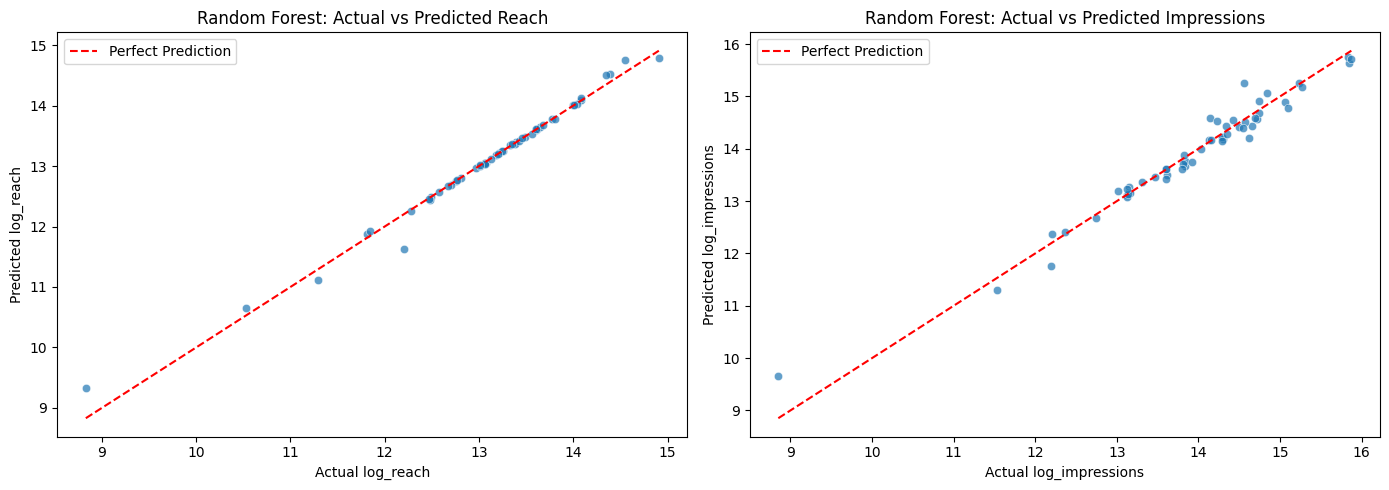

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest Predictions
rf_preds_awareness = rf_multi_awareness.predict(X_test_awareness)

# Set up the plot
plt.figure(figsize=(14, 5))

# Plot for Reach
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_awareness['log_reach'], y=rf_preds_awareness[:, 0], alpha=0.7)
plt.plot([y_test_awareness['log_reach'].min(), y_test_awareness['log_reach'].max()],
         [y_test_awareness['log_reach'].min(), y_test_awareness['log_reach'].max()],
         '--r', label='Perfect Prediction')
plt.xlabel("Actual log_reach")
plt.ylabel("Predicted log_reach")
plt.title("Random Forest: Actual vs Predicted Reach")
plt.legend()

# Plot for Impressions
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_awareness['log_impressions'], y=rf_preds_awareness[:, 1], alpha=0.7)
plt.plot([y_test_awareness['log_impressions'].min(), y_test_awareness['log_impressions'].max()],
         [y_test_awareness['log_impressions'].min(), y_test_awareness['log_impressions'].max()],
         '--r', label='Perfect Prediction')
plt.xlabel("Actual log_impressions")
plt.ylabel("Predicted log_impressions")
plt.title("Random Forest: Actual vs Predicted Impressions")
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Save the Random Forest MultiOutput model
joblib.dump(rf_multi_awareness, "../models/rf_awareness_reach_impressions_model.joblib")

feature_columns = X_train_awareness.columns.tolist()
joblib.dump(X_train_awareness.columns.tolist(), "../models/awareness_model_features.pkl")

['../models/awareness_model_features.pkl']

##  Model Persistence – Awareness Campaigns

We saved the best-performing Random Forest model (`rf_multi_awareness`) for predicting both:
- `log_reach`
- `log_impressions`

-  File saved: `../models/rf_awareness_reach_impressions_model.joblib`
-  Ready for reuse in dashboarding, forecasting, or future optimizations.
